In [ ]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## 1. Import and Version Check

In [1]:
import sys
print(f"Python version: {sys.version}")
print()

Python version: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:35:28) [MSC v.1944 64 bit (AMD64)]



In [2]:
import pymc as pm
import nutpie
import arviz as az
import preliz as pz
import numpy as np

print(f"PyMC version: {pm.__version__}")
print(f"nutpie version: {nutpie.__version__}")
print(f"ArviZ version: {az.__version__}")
print(f"PreliZ version: {pz.__version__}")

PyMC version: 5.26.1
nutpie version: 0.16.3
ArviZ version: 0.22.0
PreliZ version: 0.23.0


## 2. Simple PyMC Model Test

Test basic PyMC functionality with a simple linear regression model.

In [3]:
# Generate synthetic data
np.random.seed(42)
n_data = 100
true_slope = 2.5
true_intercept = 1.0
true_sigma = 0.5

x_data = np.random.randn(n_data)
y_data = true_intercept + true_slope * x_data + true_sigma * np.random.randn(n_data)

print(f"Generated {n_data} data points")
print(f"True parameters: intercept={true_intercept}, slope={true_slope}, sigma={true_sigma}")

Generated 100 data points
True parameters: intercept=1.0, slope=2.5, sigma=0.5


In [4]:
# Build PyMC model
with pm.Model() as linear_model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Linear model
    mu = intercept + slope * x_data
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)
    
print("Model created successfully")
print(linear_model)

Model created successfully


## 3. Test Standard NUTS Sampler

Sample using PyMC's built-in NUTS sampler.

In [5]:
with linear_model:
    trace_nuts = pm.sample(1000, tune=500, chains=2, random_seed=42)
    
print("\nPyMC NUTS sampling completed")

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope, sigma]


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



PyMC NUTS sampling completed


In [6]:
# Summary statistics
print("\nPosterior summary:")
print(az.summary(trace_nuts, var_names=["intercept", "slope", "sigma"]))


Posterior summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  1.004  0.048   0.913    1.089      0.001    0.001    2747.0   
slope      2.428  0.056   2.320    2.528      0.001    0.001    2839.0   
sigma      0.482  0.034   0.420    0.543      0.001    0.001    2823.0   

           ess_tail  r_hat  
intercept    1451.0    1.0  
slope        1457.0    1.0  
sigma        1510.0    1.0  


## 4. Test nutpie Sampler

Sample using the nutpie sampler (Rust-based, should be faster).

In [9]:
# Compile the model for nutpie
compiled_model = nutpie.compile_pymc_model(linear_model)

# Sample using nutpie
trace_nutpie = nutpie.sample(compiled_model, draws=1000, tune=500, chains=2)
    
print("\nnutpie sampling completed")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,1.14,3
,1500,0,1.05,7



nutpie sampling completed


In [10]:
# Summary statistics
print("\nPosterior summary (nutpie):")
print(az.summary(trace_nutpie, var_names=["intercept", "slope", "sigma"]))


Posterior summary (nutpie):
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  1.003  0.049   0.916    1.096      0.001    0.001    2954.0   
slope      2.428  0.053   2.324    2.526      0.001    0.001    3239.0   
sigma      0.479  0.035   0.416    0.545      0.001    0.001    2911.0   

           ess_tail  r_hat  
intercept    1419.0    1.0  
slope        1507.0    1.0  
sigma        1393.0    1.0  


## 5. ArviZ Visualization

Test ArviZ plotting capabilities.

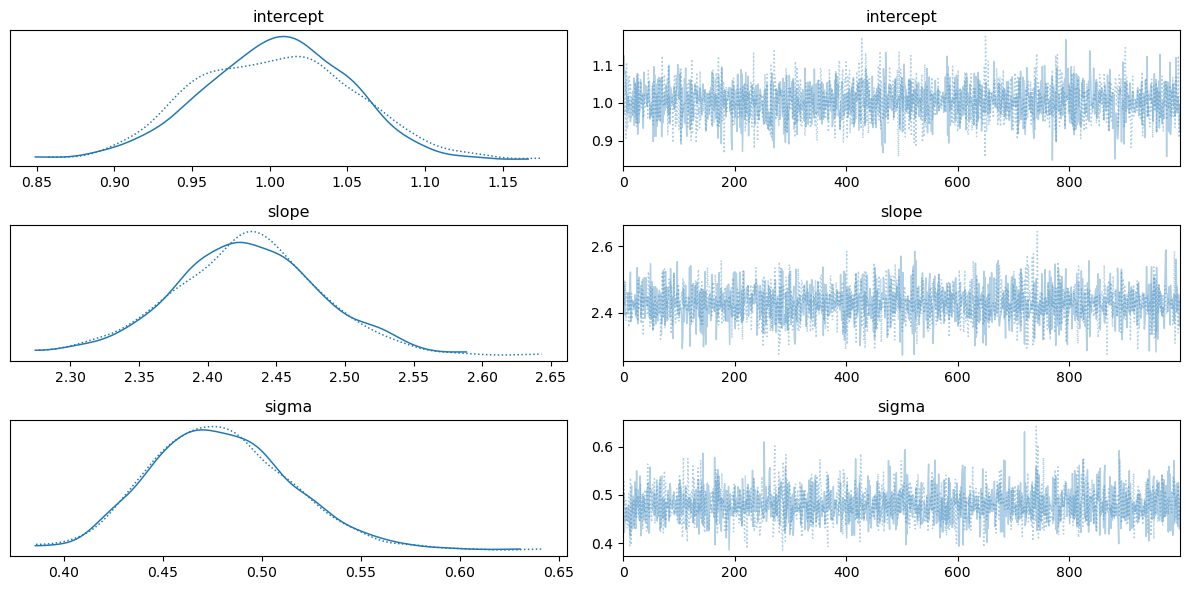

In [11]:
import matplotlib.pyplot as plt

# Trace plot
az.plot_trace(trace_nutpie, var_names=["intercept", "slope", "sigma"])
plt.tight_layout()
plt.show()

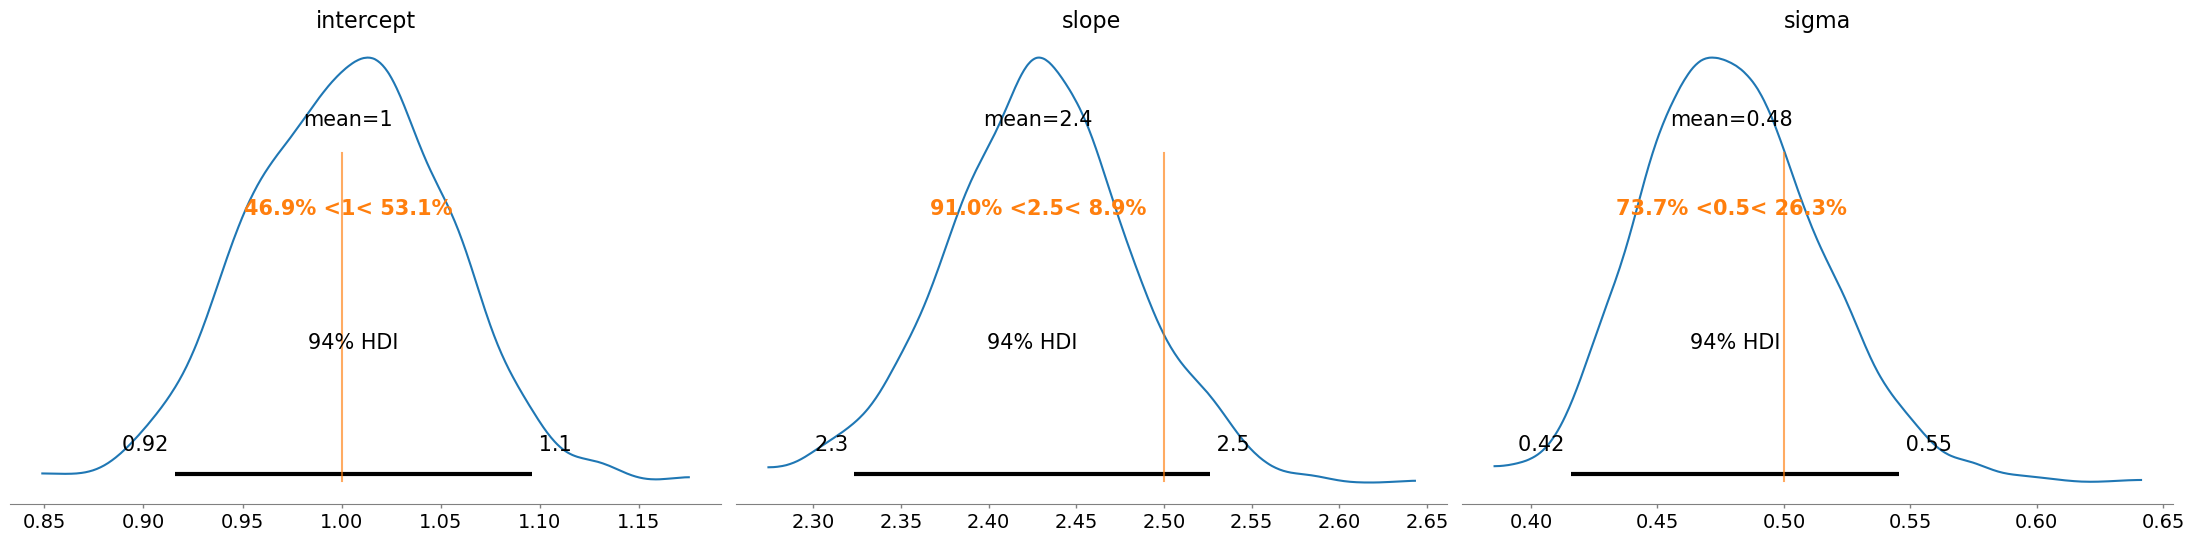

In [12]:
# Posterior plot
az.plot_posterior(trace_nutpie, var_names=["intercept", "slope", "sigma"], 
                  ref_val=[true_intercept, true_slope, true_sigma])
plt.tight_layout()
plt.show()

## 6. PreliZ Prior Exploration

Test PreliZ for prior distribution exploration.

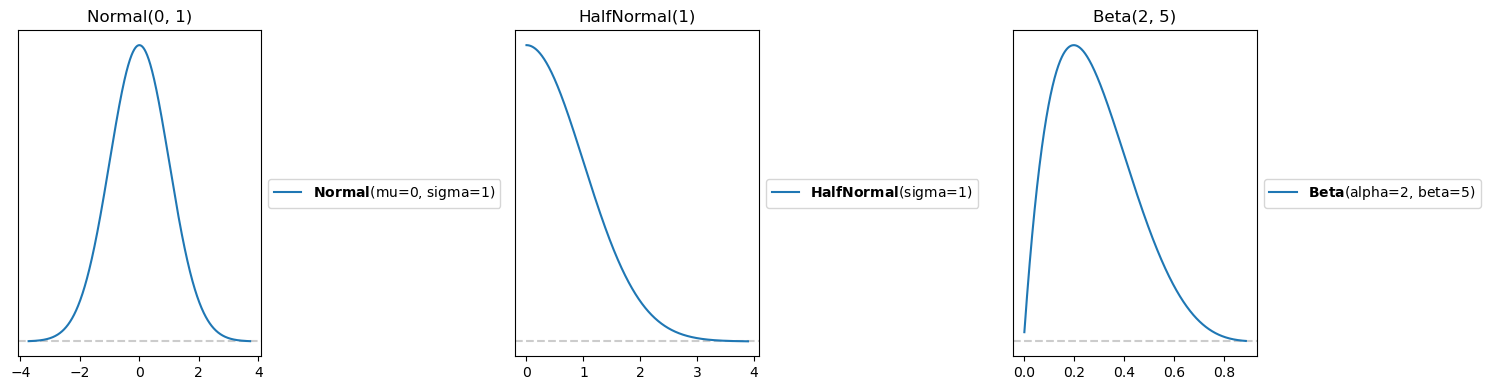

In [13]:
# Plot some common priors
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Normal prior
pz.Normal(0, 1).plot_pdf(ax=axes[0])
axes[0].set_title("Normal(0, 1)")

# Half-Normal prior
pz.HalfNormal(1).plot_pdf(ax=axes[1])
axes[1].set_title("HalfNormal(1)")

# Beta prior
pz.Beta(2, 5).plot_pdf(ax=axes[2])
axes[2].set_title("Beta(2, 5)")

plt.tight_layout()
plt.show()

## 7. Check PyTorch Compatibility

Verify that PyTorch is still working alongside PyMC.

In [14]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Simple tensor operation
x = torch.randn(3, 3)
y = torch.randn(3, 3)
z = torch.mm(x, y)
print(f"\nPyTorch tensor operations working: {z.shape}")

PyTorch version: 2.8.0
CUDA available: False

PyTorch tensor operations working: torch.Size([3, 3])


## Summary

If all cells above ran successfully, then:
- ✅ PyMC is installed and functional
- ✅ nutpie sampler is working (should be faster than standard NUTS)
- ✅ ArviZ can create diagnostic plots
- ✅ PreliZ can explore prior distributions
- ✅ PyTorch still works alongside PyMC

**Next Steps:**
- Research PyMC distributions (von Mises, von Mises-Fisher)
- Implement GIMBAL model components in PyMC
- Compare performance with custom MCMC implementation